In [64]:
from typing import Annotated

from typing import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import dateparser

from pydantic import BaseModel, Field
from typing import Optional
import yfinance as yf

In [ ]:
class StockData(TypedDict):
    symbol: str = Field(..., description="The stock symbol, e.g., TSLA, AAPL")
    time: str = Field(..., description="The time or timeframe of the query")
    price: Optional[float] = Field(None, description="The stock price if available")
    response: Optional[str] = Field(None, description="Final human-friendly response")
    message: str = Field(..., description="Original user request")
    

In [66]:

from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")

llm_with_structured_output = llm.with_structured_output(StockData)

In [80]:
import pytz

# ---- Parser Node ----
def parser_node(State: StockData) -> StockData:
    """
    Uses LLM to parse symbol and time from user request.
    """
    response = llm_with_structured_output.invoke(State["message"])
    # Merge structured output into state
    State.update(response)
    return State

# ---- Price Tool Node ----
def price_tool_node(State: StockData) -> StockData:
    """
    Calls yfinance to fetch stock price for given symbol and time.
    """
    symbol = State.get("symbol")
    time_str = State.get("time")

    if not symbol:
        State["response"] = "⚠️ No stock symbol detected in your query."
        return State

    if not time_str:
        State["response"] = "⚠️ No timeframe detected in your query."
        return State

    # Parse time string into datetime
    parsed_time = dateparser.parse(time_str)
    if not parsed_time:
        State["response"] = f"⚠️ Could not parse time: {time_str}"
        return State

    try:
        stock = yf.Ticker(symbol)
        hist = stock.history(period="10y", interval="1d")

        if hist.empty:
            State["response"] = f"⚠️ No data found for {symbol}"
            return State
        
        # ✅ Align parsed_time with index timezone
        tz = hist.index.tz  # e.g., America/New_York
        if tz is not None:
            parsed_time = pytz.timezone(str(tz)).localize(parsed_time)

        # ✅ Find the closest trading date
        nearest_idx = hist.index.get_indexer([parsed_time], method="nearest")[0]
        row = hist.iloc[nearest_idx]

        State["price"] = float(row["Close"])
        State["time"] = hist.index[nearest_idx].strftime("%Y-%m-%d")

    except Exception as e:
        State["response"] = f"❌ Error fetching stock data: {str(e)}"
        return State

    return State

# ---- Formatter Node ----
def formatter_node(State: StockData) -> StockData:
    symbol = State.get("symbol", "Unknown")
    price = State.get("price")
    time = State.get("time")

    if price is None or price == 0.0:
        State["response"] = f"⚠️ Could not retrieve a valid price for {symbol} at {time}."
    else:
        State["response"] = f"The stock price of {symbol} on {time} was ${price:.2f}."
    
    return State


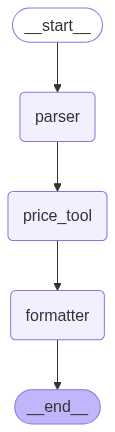

In [81]:
graph = StateGraph(StockData)

graph.add_node("parser", parser_node)
graph.add_node("price_tool", price_tool_node)
graph.add_node("formatter", formatter_node)

graph.add_edge(START, "parser")
graph.add_edge("parser", "price_tool")
graph.add_edge("price_tool", "formatter")
graph.add_edge("formatter", END)

workflow = graph.compile()
workflow

In [82]:
initial_state = {
    "message": "stock price of tesla in november 2024",
}
workflow.invoke(initial_state)



C:\Users\Acer\AppData\Local\Temp\ipykernel_7276\3377925223.py:30: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  parsed_time = dateparser.parse(time_str)


{'symbol': 'TSLA',
 'time': '2024-11-18',
 'price': 338.739990234375,
 'response': 'The stock price of TSLA on 2024-11-18 was $338.74.',
 'message': 'What is the stock price of Tesla?'}